# CPSC 330 - Applied Machine Learning 

## Homework 8: Word embeddings, time series, and communication
### Associated lectures: Lectures 17, 19, 20, and ML communication 

**Due date: April 12, 2022 at 11:59pm**

## Table of Contents

- [Submission instructions](#sg) (4%)
- [Exercise 1 - Exploring pre-trained word embeddings](#1) (24%)
- [Exercise 2 - Exploring time series data](#2) (16%)
- [Exercise 3 - Short answer questions](#4) (10%)
- [Exercise 4 - Communication](#4) (46%)
- (Optional)[Exercise 5 - Course take away](#5)

In [1]:
import os

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import DBSCAN, KMeans
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import r2_score
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler

pd.set_option("display.max_colwidth", 0)

<br><br><br><br>

## Instructions 
<hr>
rubric={points:4}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 2. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br><br><br>

## Exercise 1:  Exploring pre-trained word embeddings <a name="1"></a>
<hr>

In lecture 17, we talked about natural language processing (NLP). Using pre-trained word embeddings is very common in NLP. It has been shown that pre-trained word embeddings [work well on a variety of text classification tasks](http://www.lrec-conf.org/proceedings/lrec2018/pdf/721.pdf). These embeddings are created by training a model like Word2Vec on a huge corpus of text such as a dump of Wikipedia or a dump of the web crawl. 

A number of pre-trained word embeddings are available out there. Some popular ones are: 

- [GloVe](https://nlp.stanford.edu/projects/glove/)
    * trained using [the GloVe algorithm](https://nlp.stanford.edu/pubs/glove.pdf) 
    * published by Stanford University 
- [fastText pre-trained embeddings for 294 languages](https://fasttext.cc/docs/en/pretrained-vectors.html) 
    * trained using the fastText algorithm
    * published by Facebook
    
In this exercise, you will be exploring GloVe Wikipedia pre-trained embeddings. The code below loads the word vectors trained on Wikipedia using an algorithm called Glove. You'll need `gensim` package for that in your cpsc330 conda environment. 

```
> conda activate cpsc330
> conda install -c anaconda gensim
```

In [2]:
import gensim
import gensim.downloader

print(list(gensim.downloader.info()["models"].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [3]:
# This will take a while to run when you run it for the first time.
import gensim.downloader as api

glove_wiki_vectors = api.load("glove-wiki-gigaword-100")

In [4]:
len(glove_wiki_vectors)

400000

There are 400,000 word vectors in these pre-trained model. 

<br><br>

### 1.1 Word similarity using pre-trained embeddings
rubric={points:4}

Now that we have GloVe Wiki vectors (`glove_wiki_vectors`) loaded, let's explore the embeddings. 

**Your tasks:**

1. Calculate the cosine similarity for the following word pairs (`word_pairs`) using the [`similarity`](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) method of the model.
2. Do the similarities make sense? 

In [5]:
word_pairs = [
    ("coast", "shore"),
    ("clothes", "closet"),
    ("old", "new"),
    ("smart", "intelligent"),
    ("dog", "cat"),
    ("tree", "lawyer"),
]


In [6]:
for word_pair in word_pairs:
    similarity = glove_wiki_vectors.similarity(word_pair[0], word_pair[1])
    print("Cosine similarity between " + word_pair[0] + " and " + word_pair[1] + ": " + str(similarity))

Cosine similarity between coast and shore: 0.7000272
Cosine similarity between clothes and closet: 0.546276
Cosine similarity between old and new: 0.6432488
Cosine similarity between smart and intelligent: 0.7552732
Cosine similarity between dog and cat: 0.8798075
Cosine similarity between tree and lawyer: 0.076719455


The similarities do largely make sense with the idea of word context and usage. Tree and lawyer have a very low similarity, and the other word pairs have a high similarity. It is interesting to see the effects of the encoding, that antonyms like "old" and "new" have a pretty high similarity as they are often used in contrast to each other and in similar contexts. The highest similarity of all is "dog" and "cat", which are two different animals, but because they are so similar in usage, context, structure, simplicity, etc they have very similar encoding.

<br><br>

### 1.2 Bias in embeddings
rubric={points:10}

**Your tasks:**
1. In Lecture 17 we saw that our pre-trained word embedding model output an analogy that reinforced a gender stereotype. Give an example of how using such a model could cause harm in the real world.
2. Here we are using pre-trained embeddings which are built using a dump of Wikipedia data. Explore whether there are any worrisome biases present in these embeddings or not by trying out some examples. You can use the following two methods or other methods of your choice to explore what kind of stereotypes and biases are encoded in these embeddings. 
    - You can use the `analogy` function below which gives words analogies. 
    - You can also use [similarity](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=similarity#gensim.models.keyedvectors.KeyedVectors.similarity) or [distance](https://radimrehurek.com/gensim/models/keyedvectors.html?highlight=distance#gensim.models.keyedvectors.KeyedVectors.distances) methods. (An example is shown below.)   
3. Discuss your observations. Do you observe the gender stereotype we observed in class with GloVe Wikipedia embeddings?

> Note that most of the recent embeddings are de-biased. But you might still observe some biases in the embeddings. Also, not all stereotypes present in pre-trained embeddings are necessarily bad. But you should be aware of them when you use embeddings in your models. 

In [7]:
# modified to use the highest score
def analogy(word1, word2, word3, model=glove_wiki_vectors):
    """
    Returns analogy word using the given model.

    Parameters
    --------------
    word1 : (str)
        word1 in the analogy relation
    word2 : (str)
        word2 in the analogy relation
    word3 : (str)
        word3 in the analogy relation
    model :
        word embedding model

    Returns
    ---------------
        pd.dataframe
    """
    sim_words = model.most_similar(positive=[word3, word2], negative=[word1])
    a = pd.DataFrame(sim_words, columns=["Analogy word", "Score"])
    print("%s : %s :: %s : %s" % (word1, word2, word3, a["Analogy word"][0]))
    

An example of using similarity between words to explore biases and stereotypes.  

In [8]:
glove_wiki_vectors.similarity("white", "rich")

0.447236

In [9]:
glove_wiki_vectors.similarity("black", "rich")

0.5174519

In [10]:
print("Bias testing through the -analogy- function\n")

analogy("woman", "bad", "man")
analogy("engineer", "american", "thief")
analogy("straight", "good", "gay")
analogy("saxon", "free", "african")
analogy("switzerland", "peace", "serbia")
analogy("man", "university", "woman")
analogy("man", "ceo", "woman")
analogy("man", "career", "woman")
analogy("thief", "mexico", "programmer")

Bias testing through the -analogy- function

woman : bad :: man : good
engineer : american :: thief : thieves
straight : good :: gay : lesbian
saxon : free :: african : international
switzerland : peace :: serbia : kosovo
man : university :: woman : graduate
man : ceo :: woman : executive
man : career :: woman : professional
thief : mexico :: programmer : california


Using a biased model could cause harm in the real world. For example, a model that suggests auto-completion for texts based on a natural language processor could suggest auto-completion that reinforces stereotypes to people. Even if they don't agree and modify the text, seeing it suggested would prompt the user to think that stereotype is commonly held. Additionally, it could insult users who are affected by the stereotype when even their own device is prompting them with damaging or negative words.


I tried a lot of different things to try to find stereotypes and bias, and like we found in class it seems like this model is pretty robust to avoid that. I was able to find some very specific examples that had a questionable mapping (like "woman : bad, man : good"), but this was after trying lots of different combinations until I found it. In general, without being very selective with my words, the model performed very well in avoiding bias and stereotypes. I was able to find stereotypes in high similarities like "california : programmer" but this isn't really a harmful stereotype and isn't something I would be worried about.

<br><br>

### 1.3 Representation of all words in English
rubric={reasoning:2}

**Your tasks:**
1. The vocabulary size of Wikipedia embeddings is quite large. Do you think it contains **all** words in English language? What would happen if you try to get a word vector that's not in the vocabulary (e.g., "cpsc330"). 

In [11]:
#glove_wiki_vectors.similarity("ai", "cpsc330")

#this creates KeyError: "Key 'cpsc330' not present"

It isn't possible to contain all words in the English language, because there are even words that use misspelling, local variations, acronyms, etc to communicate specific meaning and it is impossible to find all of them.

The embedding cannot handle a word vector that is not in the vocabulary. There is no data encoded for that specific key. It's like trying to access a dictionary with a key that doesn't exist.

<br><br>

### 1.4 Classification with pre-trained embeddings
rubric={points:8}

In lecture 16, we saw that you can conveniently get word vectors with `spaCy` with `en_core_web_md` model. In this exercise, you'll use word embeddings in multi-class text classification task. We will use [HappyDB](https://www.kaggle.com/ritresearch/happydb) corpus which contains about 100,000 happy moments classified into 7 categories: *affection, exercise, bonding, nature, leisure, achievement, enjoy_the_moment*. The data was crowd-sourced via [Amazon Mechanical Turk](https://www.mturk.com/). The ground truth label is not available for all examples, and in this lab, we'll only use the examples where ground truth is available (~15,000 examples). 

- Download the data from [here](https://www.kaggle.com/ritresearch/happydb).
- Unzip the file and copy it in the lab directory.

The code below reads the data CSV (assuming that it's present in the current directory as *cleaned_hm.csv*),  cleans it up a bit, and splits it into train and test splits. 

**Your tasks:**

1. Train a logistic regression with bag-of-words features and show the classification report on the test set. 
2. Train logistic regression with average embedding representation extracted using spaCy and classification report on the test set. (You can refer to lecture 17 notes for this. Hint: you may want to consider using different [solvers](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) if you see convergence issues).  
3. Discuss your results. Which model would be more interpretable?  
4. Are you observing any benefits of transfer learning here? Briefly discuss. 

In [12]:
df = pd.read_csv("cleaned_hm.csv", index_col=0)
sample_df = df.dropna()
sample_df.head()

,wid,reflection_period,original_hm,cleaned_hm,modified,num_sentence,ground_truth_category,predicted_category
hmid,,,,,,,,
27676,206,24h,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,We had a serious talk with some friends of ours who have been flaky lately. They understood and we had a good evening hanging out.,True,2,bonding,bonding
27678,45,24h,I meditated last night.,I meditated last night.,True,1,leisure,leisure
27697,498,24h,My grandmother start to walk from the bed after a long time.,My grandmother start to walk from the bed after a long time.,True,1,affection,affection
27705,5732,24h,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,I picked my daughter up from the airport and we have a fun and good conversation on the way home.,True,1,bonding,affection
27715,2272,24h,when i received flowers from my best friend,when i received flowers from my best friend,True,1,bonding,bonding


In [13]:
sample_df = sample_df.rename(
    columns={"cleaned_hm": "moment", "ground_truth_category": "target"}
)

In [14]:
train_df, test_df = train_test_split(sample_df, test_size=0.3, random_state=123)
X_train, y_train = train_df["moment"], train_df["target"]
X_test, y_test = test_df["moment"], test_df["target"]

In [15]:
import spacy

nlp = spacy.load("en_core_web_md")

In [16]:
#Train a logistic regression with bag-of-words features and show the classification report on the test set.
#Based on Lec 17
pipe = make_pipeline(
    CountVectorizer(stop_words="english"), LogisticRegression(max_iter=1000)
)
pipe.named_steps["countvectorizer"].fit(X_train)
X_train_transformed = pipe.named_steps["countvectorizer"].transform(X_train)
pipe.fit(X_train, y_train);
print("Train accuracy {:.2f}".format(pipe.score(X_train, y_train)))
print("Test accuracy {:.2f}".format(pipe.score(X_test, y_test)))

Train accuracy 0.96
Test accuracy 0.82


In [17]:
#Train logistic regression with average embedding representation extracted using spaCy and classification report on the test set.
#Based on Lec 17
X_train_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_train)])
X_test_embeddings = pd.DataFrame([text.vector for text in nlp.pipe(X_test)])
lgr = LogisticRegression(max_iter=5000, solver='lbfgs')
lgr.fit(X_train_embeddings, y_train)
print("Train accuracy {:.2f}".format(lgr.score(X_train_embeddings, y_train)))
print("Test accuracy {:.2f}".format(lgr.score(X_test_embeddings, y_test)))

from sklearn.metrics import classification_report

y_pred = lgr.predict(X_test_embeddings)
print(classification_report(y_test, y_pred))

Train accuracy 0.85
Test accuracy 0.79
                  precision    recall  f1-score   support

     achievement       0.81      0.83      0.82      1302
       affection       0.86      0.91      0.89      1423
         bonding       0.83      0.77      0.80       492
enjoy_the_moment       0.57      0.51      0.54       469
        exercise       0.68      0.76      0.72        74
         leisure       0.72      0.65      0.68       407
          nature       0.68      0.72      0.70        71

        accuracy                           0.79      4238
       macro avg       0.74      0.74      0.73      4238
    weighted avg       0.79      0.79      0.79      4238



The bag-of-words model actually did really well. The test accuracy was 82%, while the much slower Spacy model only got a test accuracy of 79%.

In terms of interpretability, the logistic regression model with bag-of-words is likely to be more interpretable as it is based on a simpler representation of the text data. The bag-of-words representation essentially counts the frequency of words in a document, and the resulting features are integer values indicating whether a word is present or absent in the document. This makes it easy to understand which words contribute to a positive or negative sentiment. Average embedding representation extracted using spaCy is based on a more complex representation of the text data. The embedding representation uses a dense vector space to represent each word, where the distance between the vectors captures the semantic meaning of the words. This makes it more difficult to interpret which words contribute to the sentiment as the contributions of individual words are spread across multiple dimensions in the vector space.

One of the main benefits of using Spacy is transfer learning. By using pre-trained word embeddings, the model can leverage knowledge learned from large amounts of text data, which can improve its performance on the sentiment analysis task. This is because pre-trained embeddings capture the semantic relationships between words, which can help the model generalize better to new, unseen text data. We are drawing on all this data that Spacy has looked at previously to improve our own results.

So while the logistic regression model with bag-of-words is more interpretable, the logistic regression model with average embedding representation extracted using spaCy has the benefits of transfer learning.

<br><br><br><br>

## Exercise 2: Exploring time series data <a name="2"></a>
<hr>

In this exercise we'll be looking at a [dataset of avocado prices](https://www.kaggle.com/neuromusic/avocado-prices). You should start by downloading the dataset. 

In [34]:
df = pd.read_csv("avocado.csv", parse_dates=["Date"], index_col=0)
df.head()

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


In [35]:
df.shape

(18249, 13)

In [36]:
df["Date"].min()

Timestamp('2015-01-04 00:00:00')

In [37]:
df["Date"].max()

Timestamp('2018-03-25 00:00:00')

It looks like the data ranges from the start of 2015 to March 2018 (~5 years ago), for a total of 3.25 years or so. Let's split the data so that we have a 6 months of test data.

In [38]:
split_date = "20170925"
train_df = df[df["Date"] <= split_date]
test_df = df[df["Date"] > split_date]

In [39]:
assert len(train_df) + len(test_df) == len(df)

### 2.1
rubric={points:4}

In the Rain in Australia dataset from lecture, we had different measurements for each Location. What about this dataset: for which categorical feature(s), if any, do we have separate measurements? Justify your answer by referencing the dataset.

Each entry in the dataset corresponds to one of 53 days. For each day, the data is further split by a few categorical features:
First, there are entries on each day for the city or region of the observation. City/region data is further split between conventional and organic avocados. It is not a perfect split; some days have missing entries for conventional or organic avocados in one city or region. In general, however, there are entries by region and within each region between conventional and organic avocados.

<br><br>

### 2.2
rubric={points:4}

In the Rain in Australia dataset, the measurements were generally equally spaced but with some exceptions. How about with this dataset? Justify your answer by referencing the dataset.

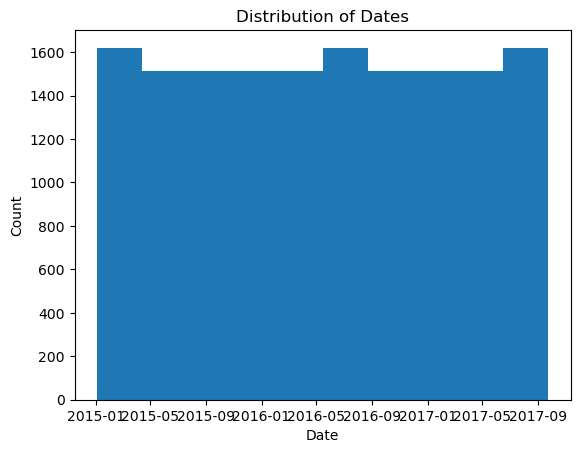

In [44]:
# Create the histogram using matplotlib
plt.hist(train_df["Date"])

# Add some labels and a title
plt.xlabel("Date")
plt.ylabel("Count")
plt.title("Distribution of Dates")
plt.show()

It seems like the measurements are also equally spaced, perhaps with some exceptions. There are some bumps on the histogram but they could just be from the way that the buckets are generated and are a very small difference that does not imply that the measurements are not equally spaced.

<br><br>

### 2.3
rubric={points:4}

In the Rain in Australia dataset, each location was a different place in Australia. For this dataset, look at the names of the regions. Do you think the regions are all distinct, or are there overlapping regions? Justify your answer by referencing the data.

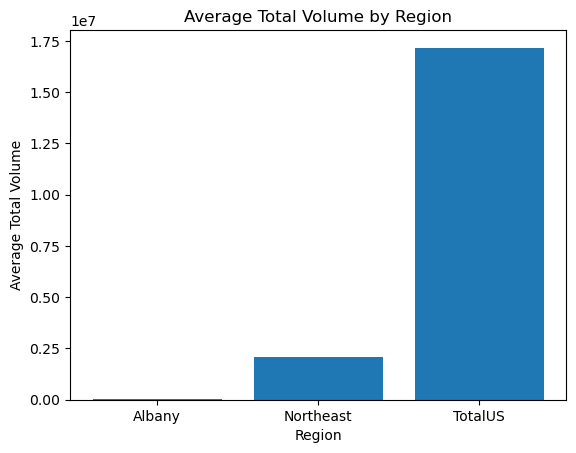

In [46]:
# Filter the data to only include 3 regions
regions = ['TotalUS', 'Northeast', 'Albany']
df_filt = train_df[train_df['region'].isin(regions)]

# Calculate the average Total Volume for each region
average_volumes = df_filt.groupby('region')['Total Volume'].mean()

# Create a bar chart
fig, ax = plt.subplots()
ax.bar(average_volumes.index, average_volumes.values)

# Set the chart title and axis labels
ax.set_title('Average Total Volume by Region')
ax.set_xlabel('Region')
ax.set_ylabel('Average Total Volume')

# Show the chart
plt.show()

Some regions are definitely overlapping. For example, there is always an entry for "TotalUS", and entries for "West", "Southeast", "Northeast", "SouthCentral", "Midsouth", etc that combine data from other regions. The "TotalUS" region has way more volume than the other entries, implying that it truly is a summation of the whole United States. Then, the regional buckets like "West" have big ammounts that are smaller than "TotalUS" but still much larger than individual cities. These regions then seem to be broken down into large cities or rural areas. So these buckets have a lot of layers of overlap. We can see that in both the names and the total volumes, which are on totally different scales and imply that many entries are bundled together into another entry. In my bar chart, you can see the totalUS, then the Northeast Region (which is within TotalUS), then Albany (which is within Northeast Region).

<br><br><br><br>

## Preparation for models

We will use the entire dataset despite any location-based weirdness uncovered in the previous part.

We would like to forecast the avocado price, which is the `AveragePrice` column. The function below is adapted from Lecture 19, with some improvements.

In [24]:
def create_lag_feature(
    df, orig_feature, lag, groupby, new_feature_name=None, clip=False
):
    """
    Creates a new feature that's a lagged version of an existing one.

    NOTE: assumes df is already sorted by the time columns and has unique indices.

    Parameters
    ----------
    df : pandas.core.frame.DataFrame
        The dataset.
    orig_feature : str
        The column name of the feature we're copying
    lag : int
        The lag; negative lag means values from the past, positive lag means values from the future
    groupby : list
        Column(s) to group by in case df contains multiple time series
    new_feature_name : str
        Override the default name of the newly created column
    clip : bool
        If True, remove rows with a NaN values for the new feature

    Returns
    -------
    pandas.core.frame.DataFrame
        A new dataframe with the additional column added.

    TODO: could/should simplify this function by using `df.shift()`
    """

    if new_feature_name is None:
        if lag < 0:
            new_feature_name = "%s_lag%d" % (orig_feature, -lag)
        else:
            new_feature_name = "%s_ahead%d" % (orig_feature, lag)

    new_df = df.assign(**{new_feature_name: np.nan})
    for name, group in new_df.groupby(groupby):
        if lag < 0:  # take values from the past
            new_df.loc[group.index[-lag:], new_feature_name] = group.iloc[:lag][
                orig_feature
            ].values
        else:  # take values from the future
            new_df.loc[group.index[:-lag], new_feature_name] = group.iloc[lag:][
                orig_feature
            ].values

    if clip:
        new_df = new_df.dropna(subset=[new_feature_name])

    return new_df

We first sort our dataframe properly:

In [25]:
df_sort = df.sort_values(by=["region", "type", "Date"]).reset_index(drop=True)
df_sort

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico
18247,2018-03-18,1.56,15896.38,2055.35,1499.55,0.00,12341.48,12114.81,226.67,0.0,organic,2018,WestTexNewMexico


We then call `create_lag_feature`. This creates a new column in the dataset `AveragePriceNextWeek`, which is the following week's `AveragePrice`. We have set `clip=True` which means it will remove rows where the target would be missing.

In [26]:
df_hastarget = create_lag_feature(
    df_sort, "AveragePrice", +1, ["region", "type"], "AveragePriceNextWeek", clip=True
)
df_hastarget

,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region,AveragePriceNextWeek
0,2015-01-04,1.22,40873.28,2819.50,28287.42,49.90,9716.46,9186.93,529.53,0.0,conventional,2015,Albany,1.24
1,2015-01-11,1.24,41195.08,1002.85,31640.34,127.12,8424.77,8036.04,388.73,0.0,conventional,2015,Albany,1.17
2,2015-01-18,1.17,44511.28,914.14,31540.32,135.77,11921.05,11651.09,269.96,0.0,conventional,2015,Albany,1.06
3,2015-01-25,1.06,45147.50,941.38,33196.16,164.14,10845.82,10103.35,742.47,0.0,conventional,2015,Albany,0.99
4,2015-02-01,0.99,70873.60,1353.90,60017.20,179.32,9323.18,9170.82,152.36,0.0,conventional,2015,Albany,0.99
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18243,2018-02-18,1.56,17597.12,1892.05,1928.36,0.00,13776.71,13553.53,223.18,0.0,organic,2018,WestTexNewMexico,1.57
18244,2018-02-25,1.57,18421.24,1974.26,2482.65,0.00,13964.33,13698.27,266.06,0.0,organic,2018,WestTexNewMexico,1.54
18245,2018-03-04,1.54,17393.30,1832.24,1905.57,0.00,13655.49,13401.93,253.56,0.0,organic,2018,WestTexNewMexico,1.56
18246,2018-03-11,1.56,22128.42,2162.67,3194.25,8.93,16762.57,16510.32,252.25,0.0,organic,2018,WestTexNewMexico,1.56


I will now split the data:

In [27]:
train_df = df_hastarget[df_hastarget["Date"] <= split_date]
test_df = df_hastarget[df_hastarget["Date"] > split_date]

<br><br>

### 2.4 Baseline
rubric={points:4}

Let's try a baseline. Previously we used `DummyClassifier` or `DummyRegressor` as a baseline. This time, we'll do something else as a baseline: we'll assume the price stays the same from this week to next week. So, we'll set our prediction of "AveragePriceNextWeek" exactly equal to "AveragePrice", assuming no change. That is kind of like saying, "If it's raining today then I'm guessing it will be raining tomorrow". This simplistic approach will not get a great score but it's a good starting point for reference. If our model does worse than this, it must not be very good. 

Using this baseline approach, what $R^2$ do you get?

<br><br>

### (Optional) 2.5 Modeling
rubric={points:2}

Now that the baseline is done, let's build some models to forecast the average avocado price a week later. Experiment with a few approachs for encoding the date. Justify the decisions you make. Which approach worked best? Report your test score and briefly discuss your results.

> because we only have 2 splits here, we need to be a bit wary of overfitting on the test set. Try not to test on it a ridiculous number of times. If you are interested in some proper ways of dealing with this, see for example sklearn's [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html), which is like cross-validation for time series data.

<br><br><br><br>

## Exercise 3: Short answer questions <a name="3"></a>

Each question is worth 2 points.

### 3.1
rubric={points:4}

The following questions pertain to Lecture 18 on time series data:

1. Sometimes a time series has missing time points or, worse, time points that are unequally spaced in general. Give an example of a real world situation where the time series data would have unequally spaced time points.
2. In class we discussed two approaches to using temporal information: encoding the date as one or more features, and creating lagged versions of features. Which of these (one/other/both/neither) two approaches would struggle with unequally spaced time points? Briefly justify your answer.

A real world situation where the time series data would have unequally spaced time points would be data where I record my scores on quizzes and tests. In general, quizzes and tests I take do not follow a specific rhythm and so would have un-equal spacing. During co-op terms, I would have no data points for many months, and after midterm time I would have a lot of data points in a short amount of time. In this case, if I was trying to predict future test scores, the dataset would have unequally spaced time points.

With unequally spaced time points, encoding the date as one or more features wouldn't really struggle. Even if the data is not well-distributed, the model can turn the points into different features encoding the time, day of the week, month, year, season, etc. The dataset might be imbalanced (many more quiz scores in the fall than in the summer) but we have already looked at ways to address that when training our models. However, with unequally spaced time points, lagged versions of features will struggle a lot. Because of the inconsistent distribution of the data, it will be difficult or impossible to select an ammount of time to lag by where time points will still have other time points to be lagged by that exact ammount of time. Even just using the previous time point as the lagged time point will also be an issue, because the previous time point could be months and months ago and not be representative anymore. In general, encoding the date as multiple features will not really be impacted by unequally spaced time points, but creating lagged versions of features will struggle a lot with unequally spaced time points.

<br><br>

### 3.2
rubric={points:6}

The following questions pertain to Lecture 19 on survival analysis. We'll consider the use case of customer churn analysis.

1. What is the problem with simply labeling customers are "churned" or "not churned" and using standard supervised learning techniques, as we did in hw4?
2. Consider customer A who just joined last week vs. customer B who has been with the service for a year. Who do you expect will leave the service first: probably customer A, probably customer B, or we don't have enough information to answer?
3. If a customer's survival function is almost flat during a certain period, how do we interpret that?

The problem is that we would be creating a model that is good at predicting if a customer would churn at the time when the dataset was collected. However, usually that isn't our true goal. If we are providing some sort of service, our goal is to avoid churn by identifying people who are soon to churn and then giving them an incentive to stay with the service. So, instead we would want to predict their time to churn, and then target customers who have a predicted short time to churn. Alternatively, it could be re-phrased into a binary classification: will the customer churn within the next XX days? This is still a yes or not (binary) question, but it is much more valuable question to answer.

In some ways we don't have enough information to answer. However, in general, I would say customer A will leave the service first. Customer B, who has already been with the service for a year, has demonstrated that they are satisfied enough with the service to stay with it for a long time. Perhaps they will leave soon if their contract is ending after a year or the service drastically worsens, but in general they seem like they will stay around. However, we don't know anything about customer A, and churn rate is highest on brand new customers. Brand new customers are trying out a new service or may be taking advantage of a free trial. They are much more likely to quit first than the customer who has already been around for a while. As I said above, though, we can't be certain about that. Customer A may become the new customer B and stay around for a long time, and customer B may have a change in circumstances that causes them to cancel.

If a customer's survival function is almost flat during a certain period, it could mean a few different things. If it is flat horizontally, it means during that time period there was no change in survival, implying that no customers churned during that time period. If a survival function is flat vertically, it means that during that time period there was a huge change in survival, implying that a large amount of customers churned in a very short amount of time.

<br><br><br><br>

## Exercise 4: Communication <a name="4"></a>
<hr>

### Exercise 4.1 Blog post 
rubric={points:40}

Write up your analysis from hw6 or any other assignment or your side machine learning related project in a "blog post" or report format. **You can write the post in Markdown in the notebook**, no need to write a real blog post (though you can if you want too!).

The target audience for your blog post is someone like yourself right before you took this course. They don't necessarily have ML knowledge, but they have a solid foundation in technical matters. The post should focus on explaining **your results and what you did** in a way that's understandable to such a person, **not** a lesson trying to teach someone about machine learning. Again: focus on the results and why they are interesting; avoid pedagogical content.

Your post must include the following elements (not necessarily in this order):

- Description of the problem/decision.
- Description of the dataset (the raw data and/or some EDA).
- Description of the model.
- Description your results, both quantitatively and qualitatively. Make sure to refer to the original problem/decision.
- A section on caveats, describing at least 3 reasons why your results might be incorrect, misleading, overconfident, or otherwise problematic. Make reference to your specific dataset, model, approach, etc. To check that your reasons are specific enough, make sure they would not make sense, if left unchanged, to most students' submissions; for example, do not just say "overfitting" without explaining why you might be worried about overfitting in your specific case.
- At least 3 visualizations. These visualizations must be embedded/interwoven into the text, not pasted at the end. The text must refer directly to each visualization. For example "as shown below" or "the figure demonstrates" or "take a look at Figure 1", etc. It is **not** sufficient to put a visualization in without referring to it directly.

A reasonable length for your entire post would be **800 words**. The maximum allowed is **1000 words**.

#### Example blog posts

Here are some examples of applied ML blog posts that you may find useful as inspiration. The target audiences of these posts aren't necessarily the same as yours, and these posts are longer than yours, but they are well-structured and engaging. You are **not required to read these** posts as part of this assignment - they are here only as examples if you'd find that useful.

From the UBC Master of Data Science blog, written by a past student:

- https://ubc-mds.github.io/2019-07-26-predicting-customer-probabilities/

This next one uses R instead of Python, but that might be good in a way, as you can see what it's like for a reader that doesn't understand the code itself (the target audience for your post here):

- https://rpubs.com/RosieB/taylorswiftlyricanalysis

Finally, here are a couple interviews with winners from Kaggle competitions. The format isn't quite the same as a blog post, but you might find them interesting/relevant:

- https://medium.com/kaggle-blog/instacart-market-basket-analysis-feda2700cded
- https://medium.com/kaggle-blog/winner-interview-with-shivam-bansal-data-science-for-good-challenge-city-of-los-angeles-3294c0ed1fb2


#### A note on plagiarism

You may **NOT** include text or visualizations that were not written/created by you. If you are in any doubt as to what constitutes plagiarism, please just ask. For more information see the [UBC Academic Misconduct policies](http://www.calendar.ubc.ca/vancouver/index.cfm?tree=3,54,111,959). Please don't copy this from somewhere 🙏. If you can't do it.

In [1]:
from IPython.display import Image

#### Blogpost on HW 6 - Predicting if a customer will cancel their reservation

In Homework 6, I was tasked with creating a model to address the goal of predicting whether a customer will cancel the reservation they have made at a hotel. It is very easy to book a hotelroom these days, both online and through a smartphone, but it is also easy to cancel. A cancellation is a problem for hotels because they might not be able to get someone in the room in time and it will be lost revenue. Therefore, a hotel would love to know if it is very likely a customer will cancel. Then, they would plan to offer more bookings than they technically have rooms for and expect that not every customer will show up. Of course, if they are wrong, they will have displeased customers clamroing for rooms they do not have.

I used the Reservation Calcellation Prediction Dataset, which you can find on Kaggle. In this dataset, each entry has 18 different pieces of information (which are called "features"), including information like the number of nights booked, number of previous cancellations, and the lead time on the reservation. Most importantly, each entry also includes if the customer ultimately cancelled their reservation or not. There are 18 thousand entries in this dataset. My goal is to use this information to create a model that can predict if a customer will cancel based on the other 17 pieces of information, which are included when a customer makes a reservation.

The model I trained is called a decision tree, which is a very intuitive model to understand. You might be familiar with simple flowcharts. In this case, to decide if a customer will cancel based on their reservation information, we could make a very simple flowchart like this one:

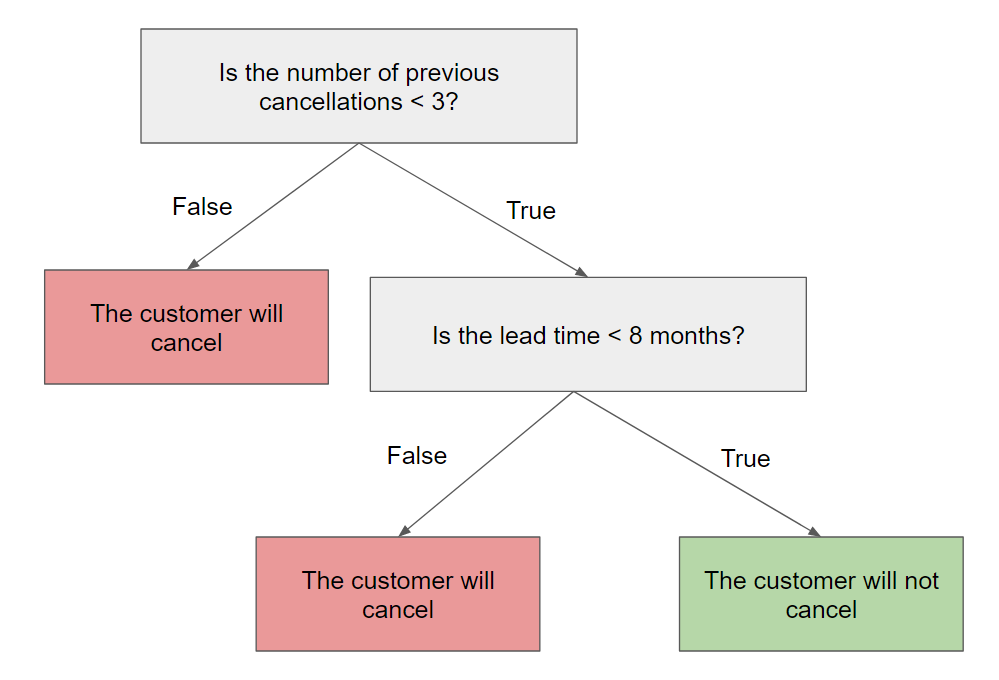

In [3]:
Image("Flowchart.png")

By answering a series of binary yes-or-no questions you arrive at an end state. In this case, you only have to answer up to two question before you make a prediction, but you could layer on more and more complexity. This is a decision tree. Each question is based on the features we know (Ex. "Does the customer have more than 3 previous cancellations?") and each answer either leads to another question or to an end state. The end states are all predictions of if the customer will cancel or not.

The computer builds a decision tree in the following way:

1. We provide the computer with a sample of data and the correct answer for each entry (called the training set)
2. The computer iteratively builds different decision trees and tests them on the training set
3. The computer selects the decision tree that gives the most correct answers

Obviously, with an infinitely large flowchart, the computer can create a branch for every entry is the training set. However, this flowchart won't work that well on new data (this type of over-optimization is called "overfitting"). An important part of training this model was making sure to limit the amount of questions it can ask the data. With a limit on the flowchart size, the computer has to find useful patterns and trends. We then hope that these patterns and trends will generalize to unseen data.

The way I tested if the model was overfitting or not was by holding back some entries and using them to test how the model handled new data. I then tried different flowchart sizes on the model to see what worked best. Below, you can see a graph of my results. The model gets better until a certain point, where it regresses and then stabilizes around a 85% accuracy. The best point is with a tree-depth (Maximum number of questions) of 13.

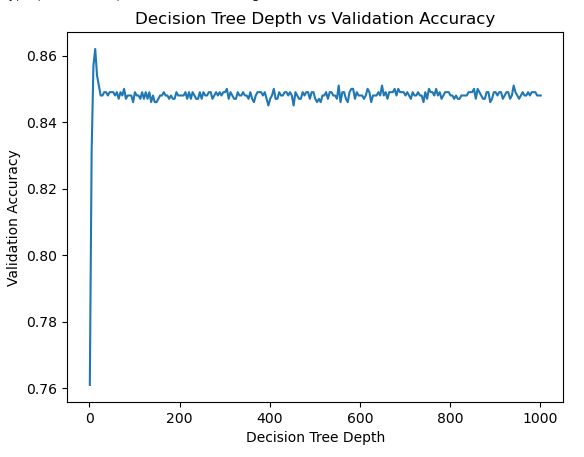

In [4]:
Image("HyperTune.png")

Once I had decided on the parameters of the model, it was time to train the final version. I gave it all of the entries in the training set and told it to generate one final decision tree with a depth of 13. Then, I took one more portion of the original data that I had kept locked away until now to test its performance. These are the results of that performance:

On the never-before-seen data, it had an accuracy of 86.2%. That means that it's prediction was right 86% of the time, and wrong the other 14%. Once again, it's important to remember that this was data that had never been exposed to the model in any way. This is an important distinction as it allows us to see how the model will react to new information before we put it out in the real world.

There are a few caveats to this model, however. I talked about how often the model was wrong (14%), but I didn't investigate what type of questions it gets wrong. Maybe all its wrong answers were saying a customer would cancel when it wouldn't, or vice versa. There is no guarantee that these wrong answers are equally distributed between predicting a cancellation and predicting no cancellation, and this difference would be very important to a real hotel.

A second caveat is that the data I used came from a European source. We can't expect that these trends or patterns would apply in the same way to other regions or countries. 

A third thing to keep in mind is that my model uses data from only 2017 and 2018. The effects of the global covid-19 pandemic have strongly altered people's relationships with hotels, and it is very likely that this model is no longer relevant even in the same regions where this data was collected. This is a huge global shift that would have to be considered before any decisions are made with this model.

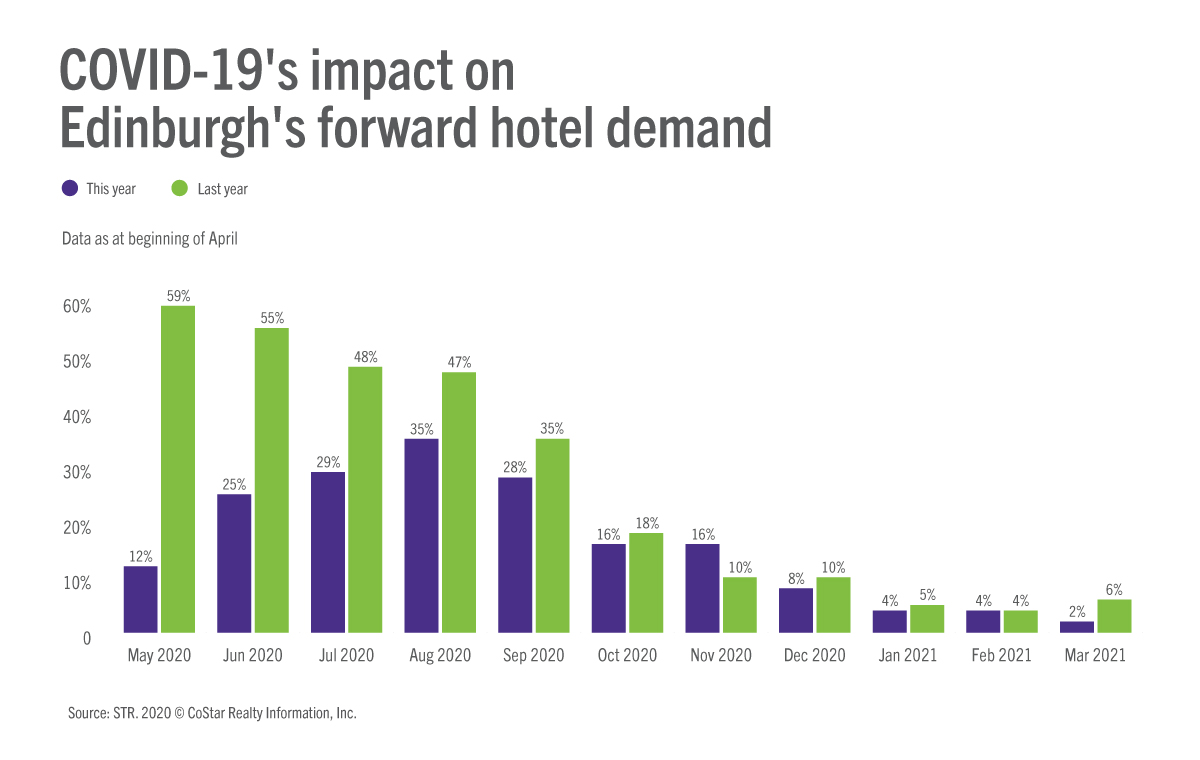

In [5]:
Image("hotelDemand.jpg")

<br><br>

### Exercise 4.2
rubric={points:6}

Describe one effective communication technique that you used in your post, or an aspect of the post that you are particularly satisfied with.

Max 3 sentences

<br><br><br><br>

### (Optional) Exercise 5 <a name="5"></a>
rubric={points:1}

**Your tasks:**

What is your biggest takeaway from this course? 

> I'm looking forward to read your answers. 

<br><br><br><br>

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 

### Congratulations on finishing all homework assignments! :clap: :clap: 

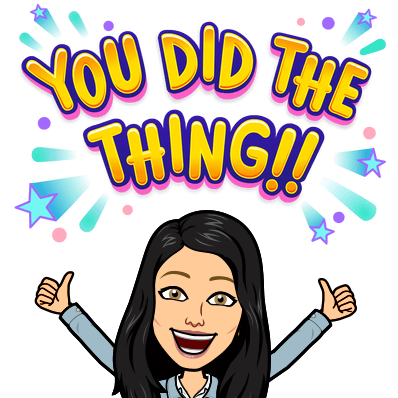

In [28]:
Image("eva-congrats.png")